In [1]:
import cv2 #opencv-python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import decode_predictions, ResNet50
import h5py
import datetime
import os
import shutil
import pathlib
import time
from IPython.display import display, Image
import pickle
from numba import cuda 
from func import * # my functions
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else "not available :(")
print("clear GPU memory...")
device = cuda.get_current_device()
device.reset() # clear GPU memory
step("Setup")

GPU available (YES!)
clear GPU memory...


✅ *Setup*

## Chargement des données

In [2]:
train_dir = "data/train"
test_dir = "data/test"
TRAINING_MODE = False # False = load model and history saved in file (much much faster) instead build it from zero
df = pd.read_csv("data/labels.csv")
df=df.sample(frac=1).reset_index(drop=True) #shuffle
df['path'] = df.id.apply(lambda x: '{}/{}.jpg'.format(train_dir, x)) # replace id by path to feed generator with flow_from_dataframe
df.drop('id', axis=1, inplace=True)
display(df.head())
step("Data loading")

,breed,path
0,sussex_spaniel,data/train/8c5b6ce48c6129af802c7a2b8c6b6a00.jpg
1,rottweiler,data/train/f2215c687883ed200475bc1bdc448622.jpg
2,bedlington_terrier,data/train/7f988b33eb8736ec69b17c498926d407.jpg
3,bedlington_terrier,data/train/2b59fa5e6e555a4f1b82cb088dbb04e4.jpg
4,english_springer,data/train/22c6358485c0c19df5f853ceacf5b9fb.jpg


✅ *Data loading*

On mélange le dataframe dès le début pour éviter de le faire par la suite ce qui pourrais compliquer notre interprétation des prédictions, notemment savoir quelle image est associée à chaque prédiction

## Créations des tenseurs

In [3]:
model_name = 'nasnet'
image_width = 331
image_size = (image_width, image_width)


generator = ImageDataGenerator(
    validation_split=0.02,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)
        
train_generator = generator.flow_from_dataframe(
    dataframe=df,
    x_col="path",
    y_col="breed",
    target_size=image_size,
    batch_size=32,
    subset="training",
    shuffle=False,
)


valid_generator = generator.flow_from_dataframe(
    dataframe=df,
    x_col="path",
    y_col="breed",
    target_size=image_size,
    batch_size=32,
    subset="validation",
    shuffle=False,
)

step("Tensor generator")

Found 10018 validated image filenames belonging to 120 classes.
Found 204 validated image filenames belonging to 120 classes.


✅ *Tensor generator*

On crée nos tenseurs à l'aide des générateurs de Tensorflow, comme nous disposons déjà d'un dataframe avec l'emplacement de nos fichiers et les labels associés on peut utiliser la fonctions **flow_from_dataframe**. On donne un nom à notre modèle qui servira à créer le fichier d'export du modèle. Toutes nos images doivent avoir **la même taille** pour avoir un traitement uniforme (un pixel = 3 données RGB). Si on a le choix on choisira 300x300 ou les recommandation du modèle pré-entrainé que l'on utilise. Il faut également **normaliser** les valeurs RGB pour cela on applique un rescale. Le batch size, c'est à dire la taille des paquet d'images qui seront soumises à chaque itération de notre entrainement est fixé à **32**, c'est la valeur qui marche la plupart du temps pour limiter le suraprentissage. **20%** de nos données seront dédiées à la validation.

## Modèle

Si aucun fichier n'existe on entraine notre modèle puis on le sauvegarde ainsi que ces stats (history)

In [4]:
model_path = 'models/' + model_name + ".h5"
history_path = 'history/' + model_name + ".h5"

if not pathlib.Path(model_path).exists() or not pathlib.Path(history_path).exists() or TRAINING_MODE:
    md("**Il n'existe pas de fichiers, on doit entrainer notre modèle complétement une première fois**")
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=2, 
        min_delta=0.001, 
        restore_best_weights=True
    )

    # Setup input shape to the model
    input_shape = [None, image_width, image_width, 3] # batch, height, width, colour channels

    # Setup output shape of the model
    output_shape = 120 # number of unique labels


    nas_model=NASNetLarge(
        include_top=False, 
        weights='imagenet', 
        input_shape=(image_width,image_width,3),
    )

    nas_model.trainable = False

    # Setup the model layers
    model = tf.keras.Sequential([
        nas_model,   
        layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(120, activation='softmax')
    ])


    # Compile the model
    opt = SGD(lr=1e-3, momentum=0.9)
    model.compile(
        optimizer = opt, 
        loss="categorical_crossentropy", 
        metrics=["accuracy"]
    )
    model.summary()

    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
    history = model.fit(
        train_generator, 
        steps_per_epoch=STEP_SIZE_TRAIN, 
        validation_data=valid_generator, 
        validation_steps=STEP_SIZE_VALID, 
        epochs=25, 
        batch_size=32, 
        callbacks=[early_stopping], 
    )
    
    
    history = history.history
    pickle.dump(history, open( history_path, "wb" ) )
    save_model(model, model_path)
    
step("Making model")

✅ *Making model*

## Evaluation

Loading saved model from: models/nasnet.h5


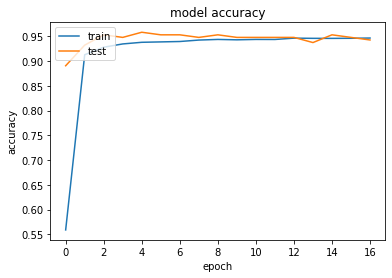

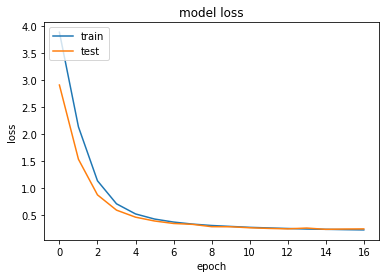

7/7 [==============================] - 11s 536ms/step


✅ *Evaluation*

In [5]:
model = load_model(model_path)
history = pickle.load(open(history_path, 'rb'))
plot_history(history)
y_pred = model.predict(valid_generator, workers=16, verbose=1)
step("Evaluation")

## Prédictions sur les données de validation

A partir des prédictions de notre modèle on va construire un dataframe avec pour chaque prédiction l'image associée et les probabilitées attribuées à chaque race de chien.

In [6]:
unique_breeds = list(pd.unique(df.breed))
unique_breeds.sort()
breed_pred = []
top10_pred = []
all_preds = []

for pred in y_pred:
    breed_pred.append(unique_breeds[np.argmax(pred)])
    top10_keys = pred.argsort()[-10:][::-1]
    top10_values = np.sort(pred)[-10:][::-1] 
    top10_pred.append(dict(zip([unique_breeds[key] for key in top10_keys], top10_values)))
    

df_pred = pd.DataFrame({'path':valid_generator.filenames, 'breed':[unique_breeds[label_index] for label_index in valid_generator.labels], 'pred': breed_pred, 'proba': top10_pred })
class_to_num = dict(zip(unique_breeds, range(120)))  # affenpinscher : 0
for name in unique_breeds:  
    df_pred[name] = y_pred[:,class_to_num[name]]

md("**Une ligne de notre dataframe de prédictions**")
display(df_pred.sample().T)
step("Predictions on validation data")

**Une ligne de notre dataframe de prédictions**

,38
path,data/train/78ba53d157186b9c4de0da5d6897a1db.jpg
breed,airedale
pred,airedale
proba,"{'airedale': 0.5732462, 'wire-haired_fox_terri..."
affenpinscher,0.000588
...,...
welsh_springer_spaniel,0.000603
west_highland_white_terrier,0.0003
whippet,0.001127
wire-haired_fox_terrier,0.232462


✅ *Predictions on validation data*

## Analyse des erreurs de prédictions

A partir de notre dataframe de prédictions on cherche à mieux visualiser les différentes érreurs de notre modèle

In [7]:
def get_error(row):
    predictions = row.proba
    if row.pred != row.breed:
        best_score = list(predictions.values())[0]
        return best_score
    else:
        return 0

key_cols = ['path', 'breed', 'pred', 'proba']

df_pred = df_pred[key_cols].copy()
df_pred["error"] = df_pred.apply(get_error, axis=1)

error_counts = len(df_pred.query("pred != breed"))
errors_percent = round(error_counts/df_pred.shape[0]*100)
print("Nombre d'erreurs du modèle sur les données de validations : {}/{} ({}%)".format(error_counts,df_pred.shape[0], errors_percent))
print("Nous avons voulu savoir quelle prédictions avaient réalisé notre modèle lorsqu'il c'est trompé, pour cela on a filtrer les mauvaises prédictions et on a retenu le score de la plus forte prédiction éronnée pour produire deux classements différents. Le premier tableau montre les races de chiens les plus difficiles à prédire (moyenne de la marge d'érreur) tandis que le second montre les races qui détériorent le plus notre modèle (sommme au lieu de la moyenne)")
md("**les races les plus difficiles à prédire:**")
display(df_pred.groupby("breed").mean("error").sort_values(by=["error"],ascending=False)[0:20])
md("**les races dont les mauvaises prédictions impactent le plus notre modèle:**")
display(df_pred.groupby("breed").sum("error").sort_values(by=["error"],ascending=False)[0:20])


Nombre d'erreurs du modèle sur les données de validations : 7/204 (3%)
Nous avons voulu savoir quelle prédictions avaient réalisé notre modèle lorsqu'il c'est trompé, pour cela on a filtrer les mauvaises prédictions et on a retenu le score de la plus forte prédiction éronnée pour produire deux classements différents. Le premier tableau montre les races de chiens les plus difficiles à prédire (moyenne de la marge d'érreur) tandis que le second montre les races qui détériorent le plus notre modèle (sommme au lieu de la moyenne)


**les races les plus difficiles à prédire:**

,error
breed,
walker_hound,0.932553
giant_schnauzer,0.663885
collie,0.532441
tibetan_mastiff,0.528251
australian_terrier,0.405690
pug,0.307631
chesapeake_bay_retriever,0.244576
affenpinscher,0.000000
miniature_schnauzer,0.000000


**les races dont les mauvaises prédictions impactent le plus notre modèle:**

,error
breed,
walker_hound,0.932553
pug,0.922892
australian_terrier,0.811379
giant_schnauzer,0.663885
collie,0.532441
tibetan_mastiff,0.528251
chesapeake_bay_retriever,0.244576
affenpinscher,0.000000
miniature_schnauzer,0.000000


### Les 50 images les plus difficiles à prédire

Voici les 50 images où le modèle a le moins performé. La bonne réponse est en vert.

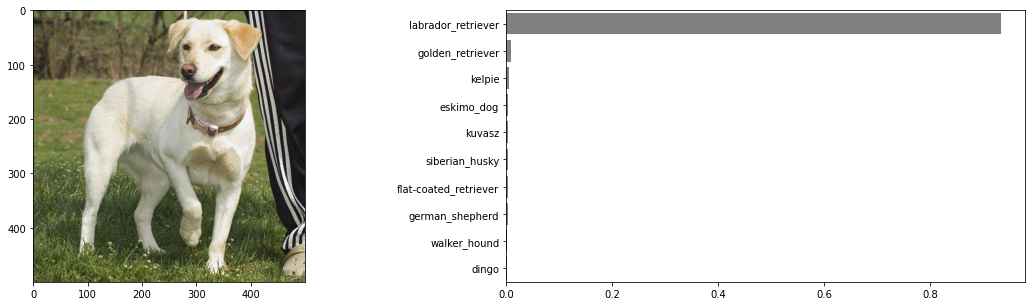

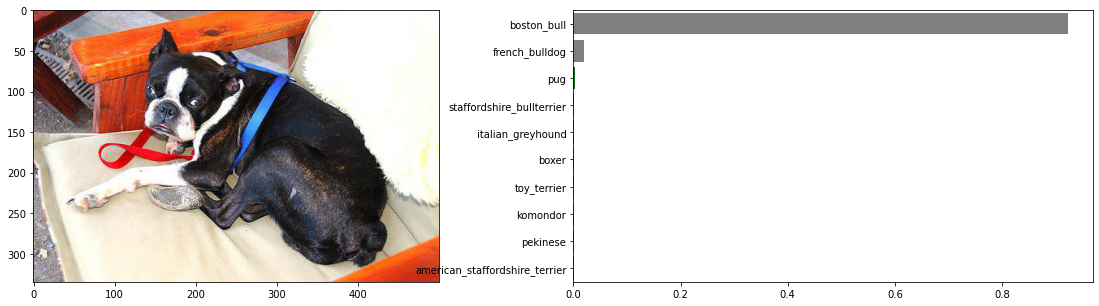

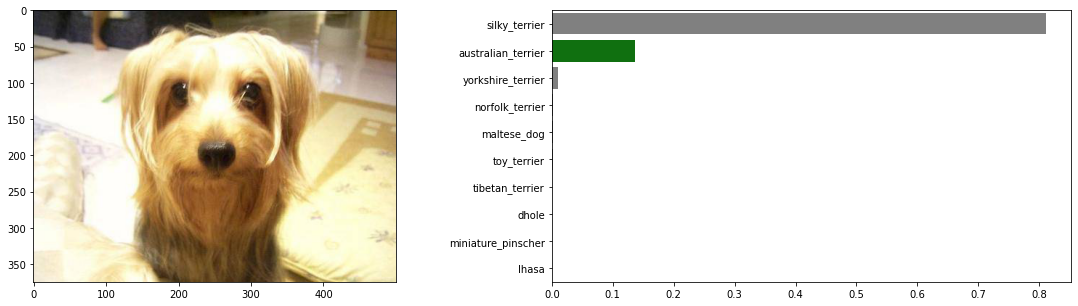

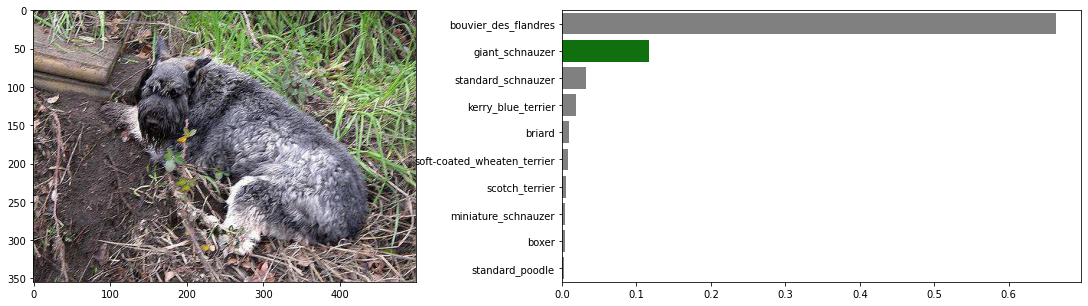

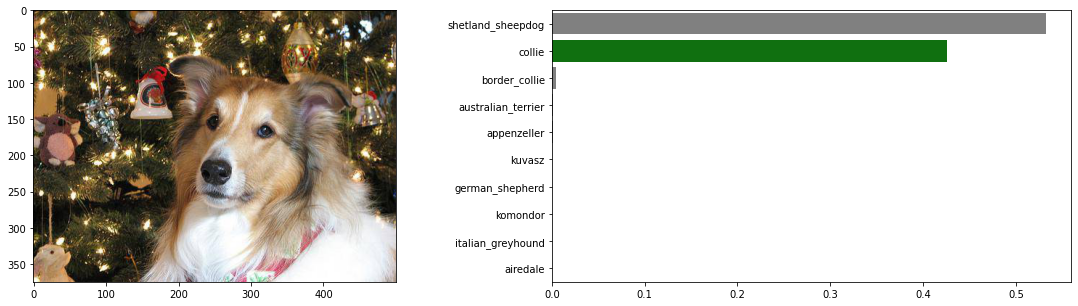

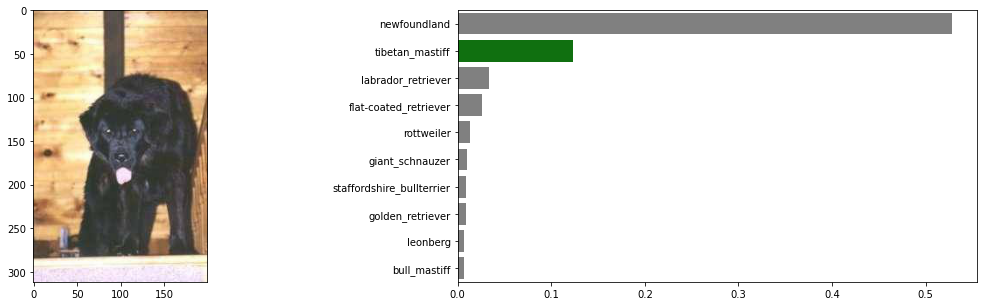

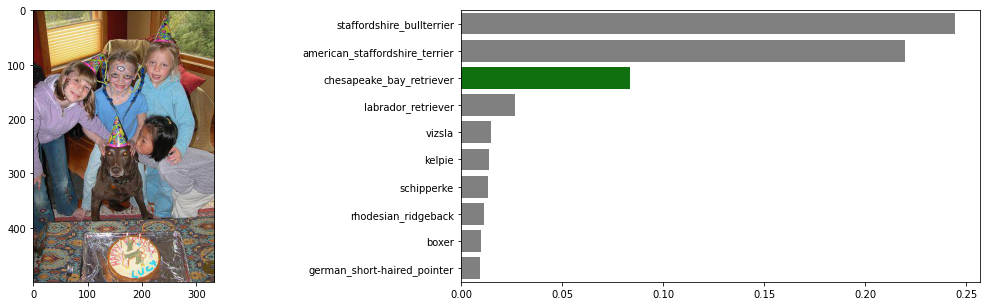

In [8]:
df_pred.query("pred != breed").sort_values(by=["error"],ascending=False).apply(plot_dog, axis=1);

In [9]:
step("Predictions details on validation data")

✅ *Predictions details on validation data*

## Création du fichier de soumission

On utilise notre modèle pour prédire les races de chiens de notre échantillion de test et on enregistre ces prédictions dans un fichier que l'on pourra soumettre à Kaggle pour obtenir un score

In [10]:
test_df = pd.read_csv("data/sample_submission.csv")

new_id = [el +".jpg" for el in test_df["id"]]
test_df["id"] = new_id



test_datagen=ImageDataGenerator(
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="id",
    y_col=None,
    target_size=image_size,
    batch_size=32,
    class_mode=None,
    shuffle=False,
)


y_pred = model.predict(test_generator)


df_sub = pd.read_csv('data/sample_submission.csv')
display(df_sub.head())

df_sub.iloc[:,1:] = y_pred
display(df_sub.head())

final_df = df_sub.set_index('id')
filename = 'my_submission.csv'
final_df.to_csv(filename)
step("Fichier de soumission crée: {}".format(filename))

Found 10357 validated image filenames.


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000142,0.000124,0.000135,0.000071,0.000139,0.000206,0.000086,0.000112,0.000106,...,0.000235,0.000167,0.000192,0.000131,0.000103,0.000144,0.000149,0.000116,0.000190,0.000160
1,00102ee9d8eb90812350685311fe5890,0.000129,0.000131,0.000177,0.000140,0.000311,0.000210,0.000138,0.000241,0.000155,...,0.000339,0.000203,0.000211,0.000190,0.000215,0.000127,0.000557,0.000224,0.000164,0.000315
2,0012a730dfa437f5f3613fb75efcd4ce,0.000117,0.000735,0.000462,0.000232,0.000196,0.000269,0.000166,0.000201,0.000324,...,0.000167,0.000193,0.000439,0.000488,0.000577,0.000488,0.000113,0.000260,0.000229,0.000294
3,001510bc8570bbeee98c8d80c8a95ec1,0.001167,0.000692,0.000366,0.000186,0.001915,0.001482,0.000207,0.000450,0.000401,...,0.000683,0.000754,0.000657,0.000296,0.000712,0.000243,0.000383,0.001378,0.000245,0.000632
4,001a5f3114548acdefa3d4da05474c2e,0.011275,0.000561,0.000686,0.000330,0.000384,0.001011,0.000662,0.000477,0.000628,...,0.000931,0.000581,0.000412,0.000395,0.000439,0.000294,0.000456,0.000501,0.000675,0.001660


✅ *Fichier de soumission crée: my_submission.csv*

In [11]:
print("clear GPU memory...")
device.reset() # clear GPU memory

clear GPU memory...
